In [2]:
from langchain_core.prompts import ChatPromptTemplate,MessagesPlaceholder
from langchain_groq import ChatGroq
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
import sqlite3
from pprint import pprint
from typing import TypedDict, List, Annotated, Union, Dict, Any
from langchain_core.messages import BaseMessage,AIMessage,HumanMessage,SystemMessage
from pydantic import BaseModel, Field
import json
import matplotlib.pyplot as plt
from langgraph.graph import StateGraph, END, add_messages
import operator
from langchain_core.tools import tool
from datetime import datetime
load_dotenv()

True

In [4]:
### generating a schema description ##
conn = sqlite3.connect('/home/shivargha/langGraph-agentic-playground/SQLQuery_Agent/Chinook_Sqlite.sqlite')
cursor = conn.cursor()
## Select all tables ##
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = [row[0] for row in cursor.fetchall()]
schema_description = ""
for table in tables:
    cursor.execute(f"PRAGMA table_info({table})")
    columns = cursor.fetchall()
    schema_description += f"\nTable: {table}\n"
    for col in columns:
        schema_description += f" - {col[1]} ({col[2]})\n"

In [5]:
pprint(schema_description)

('\n'
 'Table: Album\n'
 ' - AlbumId (INTEGER)\n'
 ' - Title (NVARCHAR(160))\n'
 ' - ArtistId (INTEGER)\n'
 '\n'
 'Table: Artist\n'
 ' - ArtistId (INTEGER)\n'
 ' - Name (NVARCHAR(120))\n'
 '\n'
 'Table: Customer\n'
 ' - CustomerId (INTEGER)\n'
 ' - FirstName (NVARCHAR(40))\n'
 ' - LastName (NVARCHAR(20))\n'
 ' - Company (NVARCHAR(80))\n'
 ' - Address (NVARCHAR(70))\n'
 ' - City (NVARCHAR(40))\n'
 ' - State (NVARCHAR(40))\n'
 ' - Country (NVARCHAR(40))\n'
 ' - PostalCode (NVARCHAR(10))\n'
 ' - Phone (NVARCHAR(24))\n'
 ' - Fax (NVARCHAR(24))\n'
 ' - Email (NVARCHAR(60))\n'
 ' - SupportRepId (INTEGER)\n'
 '\n'
 'Table: Employee\n'
 ' - EmployeeId (INTEGER)\n'
 ' - LastName (NVARCHAR(20))\n'
 ' - FirstName (NVARCHAR(20))\n'
 ' - Title (NVARCHAR(30))\n'
 ' - ReportsTo (INTEGER)\n'
 ' - BirthDate (DATETIME)\n'
 ' - HireDate (DATETIME)\n'
 ' - Address (NVARCHAR(70))\n'
 ' - City (NVARCHAR(40))\n'
 ' - State (NVARCHAR(40))\n'
 ' - Country (NVARCHAR(40))\n'
 ' - PostalCode (NVARCHAR(10))\n'
 ' 

In [6]:
llm_model = ChatGoogleGenerativeAI(model = 'gemini-2.0-flash',max_retries=2)
template = '''
You are an expert SQL data analyst, you convert natural language questions into correct and optimised SQL queries.
You are working with the following database schema:
{schema_database}

Description about the database:
The Chinook database is a sample SQL database that simulates a digital music store. \
It contains tables for artists, albums, tracks, customers, invoices, and employees 

Here is the user question:
{user_query}

Your task outline is:
1. Understand the user's query and intent
2. Identify the relevant tables and columns
3. Join tables correctly if needed
4. Filter and aggregate results appropriately
5. Return the SQL query only
'''
sql_prompt_template = ChatPromptTemplate.from_template(template)
# sql_generation = prompt_template | llm_model

In [89]:
class AgentState(TypedDict):
    messages: Annotated[List[BaseMessage],add_messages]
    question: HumanMessage
    on_topic_classifier: str ##on topic or off topic classifier
    next_tool_selection: Union[str,None]
    sql_query: str #Union[str,None] ##stores the SQL syntax###
    sql_query_columns: List[str]
    sql_result: Annotated[List[str],operator.concat]

In [8]:
class ClassifyQuestion(BaseModel):
    on_topic_label:str = Field(description = 'Is the question based on the schema described and can be\
                                            converted into a SQL Query?If yes -> "Yes" if not -> "No"')
    
def on_topic_classifier(state:AgentState):
    print("Inside On Topic Classifier, at present the state is:",state)
    recent_question = state['question'].content
    sys_message = SystemMessage(content= """ You are classifier that determine's if the user's question is about the following database:
            The Chinook database is a sample SQL database that simulates a digital music store. \
            It contains tables for artists, albums, tracks, customers, invoices, and employees.
            The following is the schema description of the database:
            {schema_database}
            Use the database description and schema description to understand,\
            if the question is relevant and is in the bounds of the above database, respond with a 'Yes'.Otherwise respond with a 'No'
                                    """.format(schema_database=schema_description))
    human_message = HumanMessage(content=f"User Question: {state['question'].content}")
    classfier_prompt_template = ChatPromptTemplate.from_messages([sys_message,human_message])
    structure_llm = llm_model.with_structured_output(ClassifyQuestion)
    classifier_chain = classfier_prompt_template | structure_llm
    on_topic_res = classifier_chain.invoke({})
    state['on_topic_classifier'] = str(on_topic_res.on_topic_label.strip())
    return state

In [9]:
##test the on topic node ##
on_topic_classifier({'question':HumanMessage(content="List all customers in alphabetical order")})

Inside On Topic Classifier, at present the state is: {'question': HumanMessage(content='List all customers in alphabetical order', additional_kwargs={}, response_metadata={})}


{'question': HumanMessage(content='List all customers in alphabetical order', additional_kwargs={}, response_metadata={}),
 'on_topic_classifier': 'Yes'}

In [110]:
class SQLOutput(BaseModel):
    sql_query:str = Field(...,description="SQL Query generated")
    sql_column_names:List[str] = Field(...,description = "List of column names after data extraction")

def SQLGenerator(state:AgentState):
    print("inside the SQLGenerator agent; state at the moment:",state)
    recent_question = state['question'].content
    structure_llm = llm_model.with_structured_output(SQLOutput)
    sql_generation = sql_prompt_template | structure_llm
    state['messages'].append(HumanMessage(content=recent_question))
    sql_query_out = sql_generation.invoke({"schema_database":schema_description,"user_query":recent_question})
    print(sql_query_out)
    state['sql_query'] = sql_query_out.sql_query
    state['sql_query_columns'] = sql_query_out.sql_column_names
    state['next_tool_selection'] = 'sqlexecutor'
    state['messages'].append(AIMessage(content=sql_query_out.sql_query))
    return state

In [ ]:
state_after_sqlgen = SQLGenerator({"messages":[],'sql_result':"",\
                                   "question":HumanMessage(content="List all albums released my metallica")})
state_after_sqlgen 

inside the SQLGenerator agent; state at the moment: {'messages': [], 'sql_result': '', 'question': HumanMessage(content='List all albums released my metallica', additional_kwargs={}, response_metadata={})}


In [105]:
def SQLExecutor(state:AgentState):
    if state['next_tool_selection'] == 'sqlexecutor':
        sql_query_code = state['sql_query']
        try:
            conn = sqlite3.connect("/home/shivargha/langGraph-agentic-playground/SQLQuery_Agent/Chinook_Sqlite.sqlite")
            result = conn.execute(sql_query_code).fetchall()
            
            print(result)
            
            if len(state['sql_query_columns']) == 1:
                #print([i[0] for i in result])
                result = [i[0] for i in result]
                state['sql_result'] = json.dumps(result)

            else:
                data1 = []
                data2 = []
                col_names_reindexed = []
                for i in result:
                    if len(i) > 1:
                        data1.append(i[0])
                        data2.append(i[1])
                print(data1,data2)
                column_names = state_after_sqlexec['sql_query_columns']
                title = state_after_sqlexec['question'].content

                ##############################################################
                
                if all(isinstance(x, str) for x in data1):
                    print('1a')
                    if all(isinstance(x, int) for x in data2):
                        print('1b')
                        dict_data = {k:v for k,v in zip(data1,data2)}
                        col_names_reindexed = column_names
                        state['sql_result'] = json.dumps(dict_data)
                        #state['sql_query_columns']
                    elif all(isinstance(x, float) for x in data2):
                        print('1b')
                        dict_data = {k:v for k,v in zip(data1,data2)}
                        col_names_reindexed = column_names
                        state['sql_result'] = json.dumps(dict_data)
                        
                elif all(isinstance(x, str) for x in data2):
                    if all(isinstance(x, int) for x in data1):
                        dict_data = {k:v for k,v in zip(data2,data1)}
                        col_names_reindexed = column_names[::-1]
                        state['sql_result'] = json.dumps(dict_data)
                        state['sql_query_columns'] = col_names_reindexed
                        
                    elif all(isinstance(x, float) for x in data1):
                        dict_data = {k:v for k,v in zip(data2,data1)}
                        col_names_reindexed = column_names[::-1]
                        state['sql_result'] = json.dumps(dict_data)
                        state['sql_query_columns'] = col_names_reindexed

            ####################################################################################

            #  #################### Data for Line Chart ###################################

            #     elif all(datetime.strptime(date, format)  for date in data1):
            #         print(1)
            #         if all(isinstance(x, float) for x in data2):
            #             dict_data = {k:v for k,v in zip(data1,data2)}
            #             #print(dict_data)
            #             col_names_reindexed = column_names
            #             state['sql_result'].append(json.dumps(dict_data))
            #         elif all(isinstance(x, int) for x in data2):
            #             dict_data = {k:v for k,v in zip(data1,data2)}
            #             #print(dict_data)
            #             col_names_reindexed = column_names
            #     else:
            #         print('Y')
            #         dict_data = {k:v for k,v in zip(data2,data1)}
            #         col_names_reindexed = column_names[::-1]
                    
            # ####################################################################################
                                
            return state
        except Exception as error:
            #state['sql_result'].append(json.dumps(result))
            print(error)
            return state

In [106]:
state_after_sqlexec = SQLExecutor(state_after_sqlgen)
state_after_sqlexec

[('Argentina', 37.62), ('Australia', 37.62), ('Austria', 42.62), ('Belgium', 37.62), ('Brazil', 190.1), ('Canada', 303.96), ('Chile', 46.62), ('Czech Republic', 90.24), ('Denmark', 37.62), ('Finland', 41.62), ('France', 195.1), ('Germany', 156.48), ('Hungary', 45.62), ('India', 75.26), ('Ireland', 45.62), ('Italy', 37.62), ('Netherlands', 40.62), ('Norway', 39.62), ('Poland', 37.62), ('Portugal', 77.24), ('Spain', 37.62), ('Sweden', 38.62), ('USA', 523.06), ('United Kingdom', 112.86)]
['Argentina', 'Australia', 'Austria', 'Belgium', 'Brazil', 'Canada', 'Chile', 'Czech Republic', 'Denmark', 'Finland', 'France', 'Germany', 'Hungary', 'India', 'Ireland', 'Italy', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Spain', 'Sweden', 'USA', 'United Kingdom'] [37.62, 37.62, 42.62, 37.62, 190.1, 303.96, 46.62, 90.24, 37.62, 41.62, 195.1, 156.48, 45.62, 75.26, 45.62, 37.62, 40.62, 39.62, 37.62, 77.24, 37.62, 38.62, 523.06, 112.86]
1a
1b


{'messages': [HumanMessage(content='Show Total sales for each country', additional_kwargs={}, response_metadata={}),
  AIMessage(content='SELECT BillingCountry, SUM(Total) AS TotalSales FROM Invoice GROUP BY BillingCountry', additional_kwargs={}, response_metadata={})],
 'sql_result': '{"Argentina": 37.62, "Australia": 37.62, "Austria": 42.62, "Belgium": 37.62, "Brazil": 190.1, "Canada": 303.96, "Chile": 46.62, "Czech Republic": 90.24, "Denmark": 37.62, "Finland": 41.62, "France": 195.1, "Germany": 156.48, "Hungary": 45.62, "India": 75.26, "Ireland": 45.62, "Italy": 37.62, "Netherlands": 40.62, "Norway": 39.62, "Poland": 37.62, "Portugal": 77.24, "Spain": 37.62, "Sweden": 38.62, "USA": 523.06, "United Kingdom": 112.86}',
 'question': HumanMessage(content='Show Total sales for each country', additional_kwargs={}, response_metadata={}),
 'sql_query': 'SELECT BillingCountry, SUM(Total) AS TotalSales FROM Invoice GROUP BY BillingCountry',
 'sql_query_columns': ['BillingCountry', 'TotalSale

In [ ]:
data2 =37.62, 37.62, 42.62, 37.62, 190.1, 303.96, 46.62, 90.24, 37.62, 41.62, 195.1, 156.48, 45.62, 75.26, 45.62, 37.62,\
40.62, 39.62, 37.62, 77.24, 37.62, 38.62, 523.06, 112.86]


In [36]:
@tool
def text_listing_tool(data: List[List[str]], title: str) -> str:
    """
    Gives out bullet points from textual data extracted from SQL query results.

    Args:
        data (List[List[str]]): A list of lists, each representing a row of 
        SQL query results. All values are expected to be strings.
        
        title (str): A title that summarizes the result.

    Returns:
        str: A formatted string with bullet points for each row.
    """
    output = [f"{title}:"]
    for row in data:
        if len(row) == 1:
            output.append(f"* {row[0]}")
        else:
            output.append(f"* {' | '.join(row)}")
    return "\n".join(output)
        #print("\n")
    #column_names = state_after_sqlexec['sql_query_columns']
# title = state_after_sqlexec['question'].content
# text_listing_tool(data_extracted,title)

In [20]:
@tool
def bar_chart_tool(data:List[Dict[str,Any]],x_axis:str,y_axis:str,title:str):
    '''
    Generates a bar chart from SQL query results containing categorical and numeric data.

    This tool is intended for use when the SQL output includes one categorical column 
    (e.g., names, genres, countries) and one numeric column (e.g., sales, counts, durations). 
    It creates a bar chart visualization to highlight comparisons between categories.

    Args:
        sql_result (List[dict]): A list of dictionaries, where each dictionary represents 
        a row of SQL output with exactly one string key (for x-axis) and one numeric value 
        (for y-axis) and the title(str) to be used for title of the plot.

    Returns:
        str: File path or base64-encoded image of the generated bar chart, suitable for 
        embedding in UI or returning in an agent output.
    
    Example: 
    data : {'The Trooper': 5,
                 'Untitled': 4,
                 'The Number Of The Beast': 4,
                 'Sure Know Something': 4,
                 'Hallowed Be Thy Name': 4}, 
         x_axis: column_name1, 
         y_axis: column_name2, 
         title:question
        
    '''
    plt.figure(figsize=(11,13))
    plt.bar(list(dict_data.keys()), list(dict_data.values()),width=0.3)
    plt.title(title)
    plt.xlabel(x_axis,fontweight='bold')
    plt.ylabel(y_axis,fontweight='bold')
    #plt.xticks(rotation=90)
    plt.show()
    save_path = "barchart.png"
    plt.savefig(save_path)
    return save_path

In [30]:
@tool
def line_chart_tool(data:List[Dict[str,Any]],x_axis:str,y_axis:str,title:str):
    '''
    Generates a line chart from time series SQL query results.

    This tool is intended for use when the SQL output includes a date/time column 
    (typically formatted as 'YYYY-MM' or full datetime) and a numeric column 
    representing values over time (e.g., sales, revenue, user signups).

    Args:
        sql_result (List[dict]): A list of dictionaries, each containing a time-based 
        key (x-axis) and a corresponding numeric value (y-axis) and the title(str) to be used for title of the plot. 
        The time values should be parseable into datetime objects.
        
        
    Returns:
        str: File path or base64-encoded image of the generated line chart, suitable 
        for visual representation in agent output or UI.
    
    
    Example data
    data : {'2013-01': 37.62,
             '2013-02': 27.72,
             '2013-03': 37.62,
             '2013-04': 33.66,
             '2013-05': 37.62,
             '2013-06': 37.62,
             '2013-07': 37.62,
             '2013-08': 37.62,
             '2013-09': 37.62,
             '2013-10': 37.62,
             '2013-11': 49.62,
             '2013-12': 38.62}, x_axis: column_name1, y_axis: column_name2, title:question
        
    '''
    plt.figure(figsize=(11,13))
    plt.plot(list(data.keys()), list(data.values()), linewidth=2)
    plt.xlabel(x_axis,fontweight='bold')
    plt.ylabel(y_axis,fontweight='bold')
    plt.title(title)
    plt.show()
    save_path = "linechart.png"
    plt.savefig(save_path)
    return save_path

In [22]:
data_extracted = json.loads(state_after_sqlexec['sql_result'][-1])
data_extracted

[['Garage Inc. (Disc 1)'],
 ['Black Album'],
 ['Garage Inc. (Disc 2)'],
 ["Kill 'Em All"],
 ['Load'],
 ['Master Of Puppets'],
 ['ReLoad'],
 ['Ride The Lightning'],
 ['St. Anger'],
 ['...And Justice For All']]

In [296]:
format = "%Y-%m"
date = '2013-11'
res = bool(datetime.strptime(date, format))
res

True

In [302]:
if all(datetime.strptime(date, format) for date in data1):
    print(1)

1


In [357]:
##Text only##
data1 = []
for i in data_extracted:
    #print(i)
    if len(i) == 1:
        print("*"+i[0])
        #print("\n")
column_names = state_after_sqlexec['sql_query_columns']
title = state_after_sqlexec['question'].content


*Garage Inc. (Disc 1)
*Black Album
*Garage Inc. (Disc 2)
*Kill 'Em All
*Load
*Master Of Puppets
*ReLoad
*Ride The Lightning
*St. Anger
*...And Justice For All


In [355]:
for i in data1:
    print(i)

Garage Inc. (Disc 1)
Black Album
Garage Inc. (Disc 2)
Kill 'Em All
Load
Master Of Puppets
ReLoad
Ride The Lightning
St. Anger
...And Justice For All


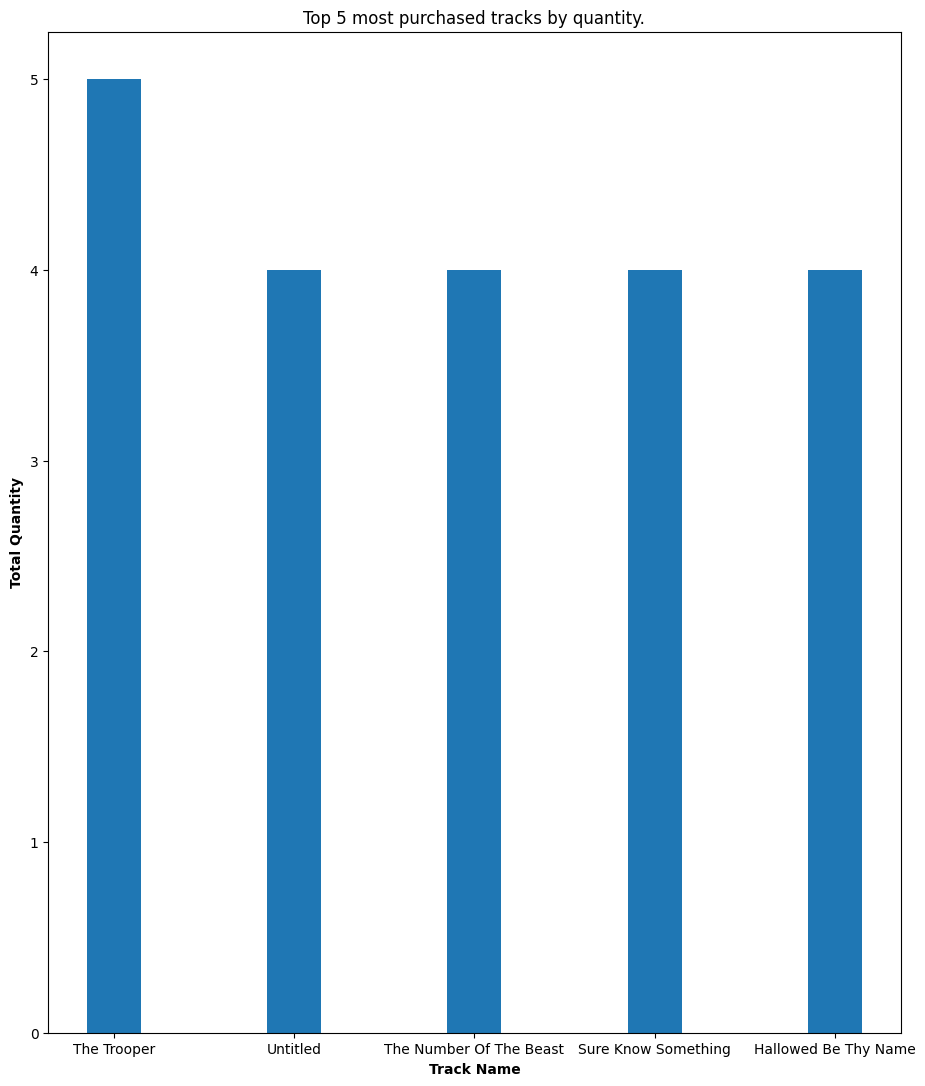

In [332]:
data1 = []
data2 = []
col_names_reindexed = []
for i in data_extracted:
    if len(i) > 1:
        data1.append(i[0])
        data2.append(i[1])
column_names = state_after_sqlexec['sql_query_columns']
title = state_after_sqlexec['question'].content
if all(isinstance(x, str) for x in data1):
    if all(isinstance(x, int) for x in data2):
        dict_data = {k:v for k,v in zip(data1,data2)}
        col_names_reindexed = column_names
else:
    dict_data = {k:v for k,v in zip(data2,data1)}
    col_names_reindexed = column_names[::-1]
dict_data
bar_chart_tool(dict_data,col_names_reindexed[0],col_names_reindexed[1],title)

['month', 'revenue'] Monthly revenue trend in 2013.
1


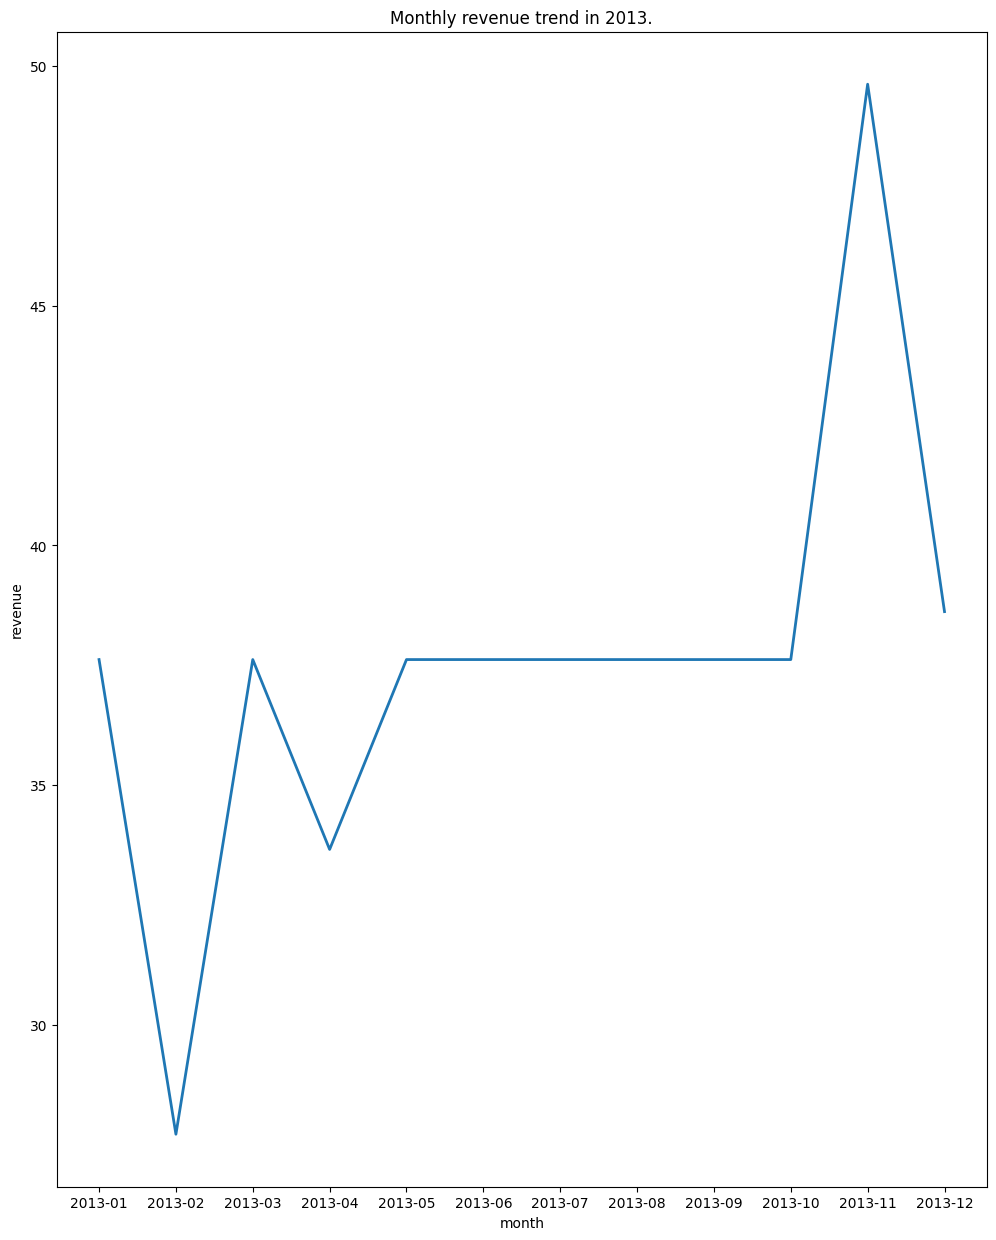

In [318]:
data1 = []
data2 = []
col_names_reindexed = []
for i in data_extracted:
    if len(i) > 1:
        data1.append(i[0])
        data2.append(i[1])
column_names = state_after_sqlexec['sql_query_columns']
title = state_after_sqlexec['question'].content
print(column_names,title)
if all(datetime.strptime(date, format)  for date in data1):
    print(1)
    if all(isinstance(x, float) for x in data2):
        dict_data = {k:v for k,v in zip(data1,data2)}
        #print(dict_data)
        col_names_reindexed = column_names
    elif all(isinstance(x, int) for x in data2):
        dict_data = {k:v for k,v in zip(data1,data2)}
        #print(dict_data)
        col_names_reindexed = column_names
else:
    dict_data = {k:v for k,v in zip(data2,data1)}
    col_names_reindexed = column_names[::-1]


dict_data
line_chart_tool(dict_data,col_names_reindexed[0],col_names_reindexed[1],title)

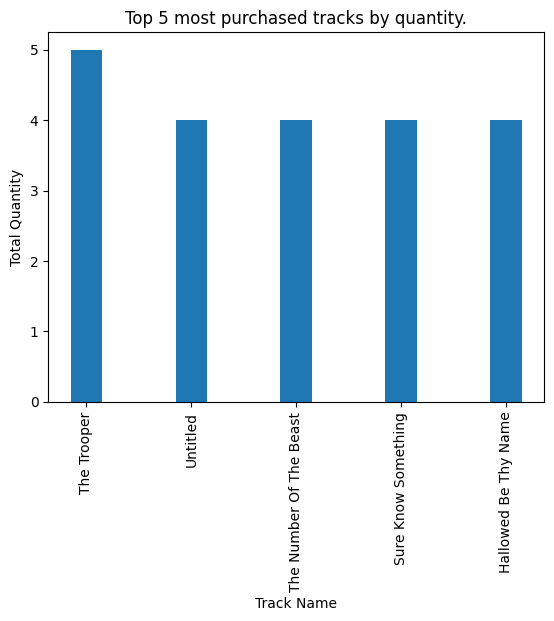

In [288]:
bar_chart_tool(dict_data,col_names_reindexed[0],col_names_reindexed[1],title)

In [259]:
dict_data

{'The Trooper': 5,
 'Untitled': 4,
 'The Number Of The Beast': 4,
 'Sure Know Something': 4,
 'Hallowed Be Thy Name': 4}

In [281]:
list(dict_data.values())

[5, 4, 4, 4, 4]

In [151]:
conn = sqlite3.connect("/home/shivargha/langGraph-agentic-playground/InsightQuery_Agent/Chinook_Sqlite.sqlite")
cursor = conn.cursor()
z = cursor.execute("SELECT t.Name FROM Track t JOIN InvoiceLine il ON t.TrackId = il.TrackId GROUP BY t.Name ORDER BY SUM(il.Quantity) DESC LIMIT 5")

In [159]:
sql = "SELECT t.Name FROM Track t JOIN InvoiceLine il ON t.TrackId = il.TrackId GROUP BY t.Name ORDER BY SUM(il.Quantity) DESC LIMIT 5"
conn.execute(sql).fetchall()

[('The Trooper',),
 ('Untitled',),
 ('The Number Of The Beast',),
 ('Sure Know Something',),
 ('Hallowed Be Thy Name',)]

In [363]:
state_after_sqlexec

{'messages': [HumanMessage(content='List all albums released my metallica', additional_kwargs={}, response_metadata={}),
  AIMessage(content='SELECT Title FROM Album JOIN Artist ON Album.ArtistId = Artist.ArtistId WHERE Artist.Name = "Metallica"', additional_kwargs={}, response_metadata={})],
 'sql_result': ['[["Garage Inc. (Disc 1)"], ["Black Album"], ["Garage Inc. (Disc 2)"], ["Kill \'Em All"], ["Load"], ["Master Of Puppets"], ["ReLoad"], ["Ride The Lightning"], ["St. Anger"], ["...And Justice For All"]]'],
 'question': HumanMessage(content='List all albums released my metallica', additional_kwargs={}, response_metadata={}),
 'sql_query': 'SELECT Title FROM Album JOIN Artist ON Album.ArtistId = Artist.ArtistId WHERE Artist.Name = "Metallica"',
 'sql_query_columns': ['Title'],
 'next_tool_selection': 'sqlexecutor'}

In [23]:
def reactNode(state:AgentState):
    tools = [text_listing_tool, bar_chart_tool, line_chart_tool]
    llm_with_tools = llm_model.bind_tools(tools)
    
    ACT_PROMPT = '''
    You are a data visualization agent. Based on the following context, choose the appropriate tool from one of the following:
    - `bar_chart_tool`: use when one column is categorical (like names, genres) and another is numeric.
    - `line_chart_tool`: use when one column is a time/date and another is numeric (e.g., monthly revenue).
    - `text_listing_tool`: use when data is purely text-based.
    
    Respond by calling the correct tool with the appropriate SQL result data.
    
    ---
    
    User Query: {user_query}
    
    LLM's SQL Response: {ai_message}
    
    SQL Query Result (sample): {sql_result}
    
    Column Names: {column_names}
    '''
    
    prompt_template = ChatPromptTemplate.from_template(ACT_PROMPT)
    chain = prompt_template | llm_with_tools
    ai_message = chain.invoke({'user_query':state_after_sqlexec['messages'][-2].content,
                 'ai_message':state_after_sqlexec['messages'][-1].content,
                 'sql_result':state_after_sqlexec['sql_result'][-1],
                 'column_names':state_after_sqlexec['sql_query_columns']})
    state['messages'].append(ai_message)
    return state

In [28]:
state_after_sqlexec

{'messages': [HumanMessage(content='List all albums released my metallica', additional_kwargs={}, response_metadata={}),
  AIMessage(content='SELECT Title FROM Album JOIN Artist ON Album.ArtistId = Artist.ArtistId WHERE Artist.Name = "Metallica"', additional_kwargs={}, response_metadata={})],
 'sql_result': ['[["Garage Inc. (Disc 1)"], ["Black Album"], ["Garage Inc. (Disc 2)"], ["Kill \'Em All"], ["Load"], ["Master Of Puppets"], ["ReLoad"], ["Ride The Lightning"], ["St. Anger"], ["...And Justice For All"]]'],
 'question': HumanMessage(content='List all albums released my metallica', additional_kwargs={}, response_metadata={}),
 'sql_query': 'SELECT Title FROM Album JOIN Artist ON Album.ArtistId = Artist.ArtistId WHERE Artist.Name = "Metallica"',
 'sql_query_columns': ['Title'],
 'next_tool_selection': 'sqlexecutor'}

In [37]:
tools = [text_listing_tool, bar_chart_tool, line_chart_tool]
#print(tools)
llm_with_tools = llm_model.bind_tools(tools)

ACT_PROMPT = '''
You are a data visualization agent. Based on the following context, choose the appropriate tool from one of the following:
- `bar_chart_tool`: use when one column is categorical (like names, genres) and another is numeric.
- `line_chart_tool`: use when one column is a time/date and another is numeric (e.g., monthly revenue).
- `text_listing_tool`: use when data is purely text-based.

Respond by calling the correct tool with the appropriate SQL result data.

---

User Query: {user_query}

LLM's SQL Response: {ai_message}

SQL Query Result (sample): {sql_result}

Column Names: {column_names}
'''

prompt_template = ChatPromptTemplate.from_template(ACT_PROMPT)
chain = prompt_template | llm_with_tools
ai_message = chain.invoke({'user_query':state_after_sqlexec['messages'][-2].content,
             'ai_message':state_after_sqlexec['messages'][-1].content,
             'sql_result':state_after_sqlexec['sql_result'][-1],
             'column_names':state_after_sqlexec['sql_query_columns']})
ai_message

ChatGoogleGenerativeAIError: Invalid argument provided to Gemini: 400 * GenerateContentRequest.tools[0].function_declarations[0].parameters.properties[data].items.items: missing field.


In [384]:
state_after_sqlexec['messages'].append(ai_message)
state_after_sqlexec

{'messages': [HumanMessage(content='List all albums released my metallica', additional_kwargs={}, response_metadata={}),
  AIMessage(content='SELECT Title FROM Album JOIN Artist ON Album.ArtistId = Artist.ArtistId WHERE Artist.Name = "Metallica"', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'text_listing_tool', 'arguments': '{"title": "List of albums released by Metallica", "data": ["Garage Inc. (Disc 1)", "Black Album", "Garage Inc. (Disc 2)", "Kill \'Em All", "Load", "Master Of Puppets", "ReLoad", "Ride The Lightning", "St. Anger", "...And Justice For All"]}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-472385fa-5913-4457-bffd-bc8aecf59a06-0', tool_calls=[{'name': 'text_listing_tool', 'args': {'title': 'List of albums released by Metallica', 'data': ['Garage Inc. (Disc 1)', 'Black Album', 'Garage Inc. (Disc 2)', "Kill 'Em

In [387]:
def exec_tool(state:AgentState):

    ##check for ai message##
    if isinstance(state['messages'][-1],AIMessage):
        ai_message = state['messages'][-1]
        if hasattr(ai_message,"tool_calls"):
            tool_messages = []
            for tool_call in ai_message.tool_calls:
                tool_call_function = tool_call['name']
                call_id = tool_call["id"]

                ### data manipulatio ###


                #########################

In [385]:
if isinstance(state_after_sqlexec['messages'][-1],AIMessage):
    print(9)

9


In [388]:
if hasattr(ai_message,"tool_calls"):
    tool_messages = []
    for tool_call in ai_message.tool_calls:
        tool_call_function = tool_call['name']
        call_id = tool_call["id"]
print(call_id,tool_call_function)

504843f2-c99c-4d60-ae7b-d4378767f098 text_listing_tool


In [ ]:
tool

In [1]:
state_tool_call.tool_calls

NameError: name 'state_tool_call' is not defined